In [37]:
import os
import numpy as np
from torchvision.datasets import CIFAR10
import torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torch import nn
import math
import skimage as ski
import skimage.io
import matplotlib.pyplot as plt
from tqdm import tqdm

In [38]:
DATA_DIR = './datasets/CIFAR-10'

img_height = 32
img_width = 32
num_channels = 3
num_classes = 10

ds_train = CIFAR10(DATA_DIR, train=True, download=True, transform=torchvision.transforms.ToTensor())
ds_test = CIFAR10(DATA_DIR, train=False, transform=torchvision.transforms.ToTensor())

n = len(ds_train)
train_size = int(n * 0.8)
valid_size = n - train_size

ds_train, ds_valid = torch.utils.data.random_split(ds_train, [train_size, valid_size])

x_train, y_train = [], []
for data in ds_train:
    x_train.append(data[0])
    y_train.append(data[1])

x_train = torch.stack(x_train)

x_val, y_val = [], []
for data in ds_valid:
    x_val.append(data[0])
    y_val.append(data[1])

x_val = torch.stack(x_val)

x_test, y_test = [], []
for data in ds_test:
    x_test.append(data[0])
    y_test.append(data[1])

x_test = torch.stack(x_test)

train_data = torch.utils.data.TensorDataset(x_train, torch.tensor(y_train))
val_data = torch.utils.data.TensorDataset(x_val, torch.tensor(y_val))
test_data = torch.utils.data.TensorDataset(x_test, torch.tensor(y_test))

Files already downloaded and verified


In [60]:
def draw_conv_filters(epoch, step, weights, save_dir):
  w = weights.copy()
  num_filters = w.shape[0]
  num_channels = w.shape[1]
  k = w.shape[2]
  assert w.shape[3] == w.shape[2]
  w = w.transpose(2, 3, 1, 0)
  w -= w.min()
  w /= w.max()
  border = 1
  cols = 8
  rows = math.ceil(num_filters / cols)
  width = cols * k + (cols-1) * border
  height = rows * k + (rows-1) * border
  img = np.zeros([height, width, num_channels])
  for i in range(num_filters):
    r = int(i / cols) * (k + border)
    c = int(i % cols) * (k + border)
    img[r:r+k,c:c+k,:] = w[:,:,:,i]
  filename = 'epoch_%02d_step_%06d.png' % (epoch, step)
  img = np.uint8(255 * img)
  ski.io.imsave(os.path.join(save_dir, filename), img)

In [42]:
def plot_training_progress(save_dir, data):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

  linewidth = 2
  legend_size = 10
  train_color = 'm'
  val_color = 'c'

  num_points = len(data['train_loss'])
  x_data = np.linspace(1, num_points, num_points)
  ax1.set_title('Cross-entropy loss')
  ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax1.legend(loc='upper right', fontsize=legend_size)
  ax2.set_title('Average class accuracy')
  ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax2.legend(loc='upper left', fontsize=legend_size)
  ax3.set_title('Learning rate')
  ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
  ax3.legend(loc='upper left', fontsize=legend_size)

  save_path = os.path.join(save_dir, 'training_plot.png')
  print('Plotting in: ', save_path)
  plt.savefig(save_path)

In [103]:
class ConvNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding='same')
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(32 * 7 * 7, 256, bias=True)
        self.fc2 = nn.Linear(256, 128, bias=True)
        self.fc3 = nn.Linear(128, num_classes, bias=True)

    def forward(self, x):
        x = self.maxpool(torch.relu(self.conv1(x)))
        x = self.maxpool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_loss(self, y, target):
        y = torch.softmax(y, dim=1)
        return nn.functional.cross_entropy(y, target)

In [104]:
SAVE_DIR = './out/convnet_training_10'

def evaluate(model, dataset, loss_fn=nn.functional.cross_entropy):
    model.eval()
    with torch.no_grad():
        x, y = dataset[:][0], dataset[:][1]
        y_ = model(x)
        loss = loss_fn(y_, y)
        y_ = torch.argmax(y_, dim=1)
        acc = (y_ == y).sum().item() / len(y)
        confussion_matrix = torch.zeros(num_classes, num_classes)
        for i in range(len(y)):
            confussion_matrix[y[i], y_[i]] += 1
        precision = confussion_matrix.diag() / confussion_matrix.sum(0)
        recall = confussion_matrix.diag() / confussion_matrix.sum(1)
    model.train()
    return loss.item(), acc, confussion_matrix, precision, recall

def train(model, train_data, valid_data, config, loss_fn=nn.functional.cross_entropy):
    train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []

    num_epochs = config['num_epochs']
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['lr_decay'])
    model.train()

    for epoch in range(1, num_epochs+1):
        with tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Training (epoch={epoch}/{num_epochs})') as epoch_progress:
            for i, (X, Yoh_) in epoch_progress:
                Y_ = model(X)
                loss = loss_fn(Y_, Yoh_)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                epoch_progress.set_postfix({'loss': loss.item()})

                if i%250 == 0:
                    draw_conv_filters(epoch, i, model.conv1.weight.data.detach().numpy(), SAVE_DIR)
            train_loss, train_acc, _, _, _ = evaluate(model, train_data, loss_fn)
            val_loss, val_acc, _, _, _ = evaluate(model, valid_data, loss_fn)

            plot_data['train_loss'] += [train_loss]
            plot_data['valid_loss'] += [val_loss]
            plot_data['train_acc'] += [train_acc]
            plot_data['valid_acc'] += [val_acc]
            plot_data['lr'] += [lr_scheduler.get_lr()]
            lr_scheduler.step()

    plot_training_progress(SAVE_DIR, plot_data)

Training (epoch=10/10): 100%|██████████| 1250/1250 [00:57<00:00, 21.85it/s, loss=1.89]


Plotting in:  ./out/convnet_training/training_plot.png


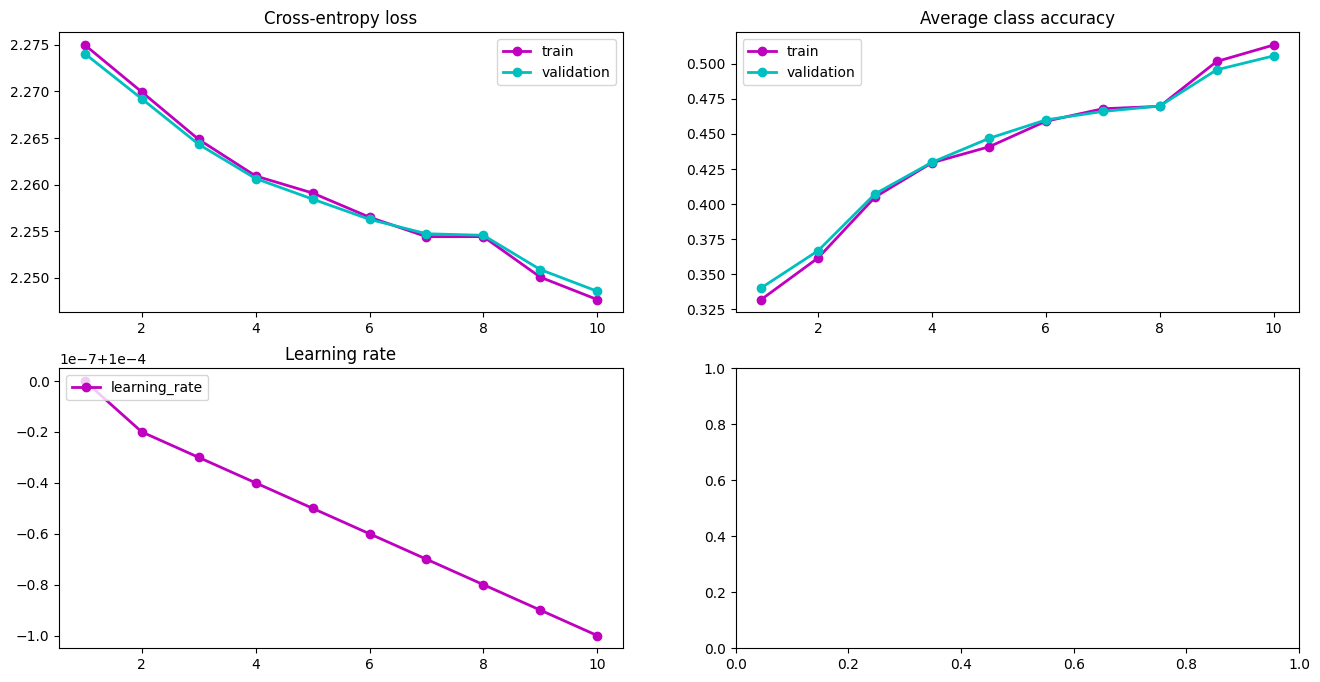

In [105]:
net = ConvNet(3, 10)

train(net, train_data, val_data, {'num_epochs':10, 'lr_decay':1-1e-4, 'lr':1e-4}, net.get_loss)

In [101]:
torch.save(net.state_dict(), os.path.join(SAVE_DIR, 'model_10epochs.pth'))

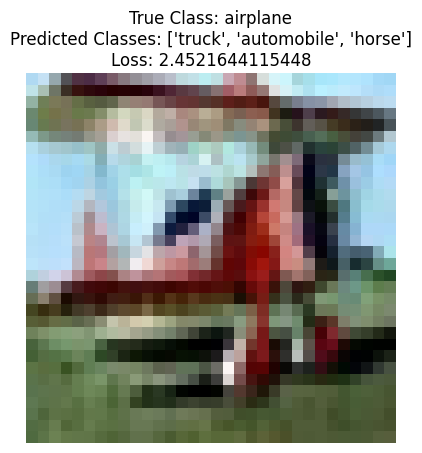

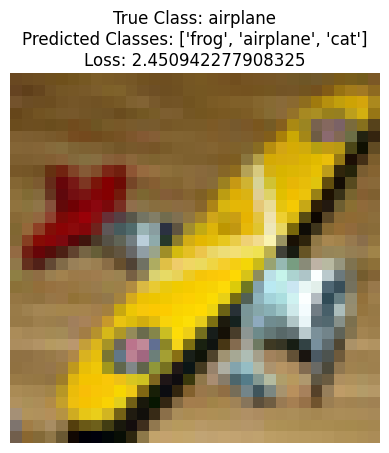

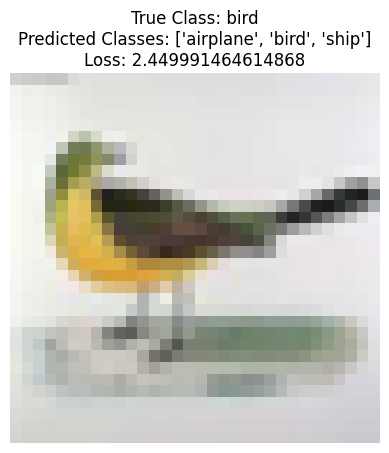

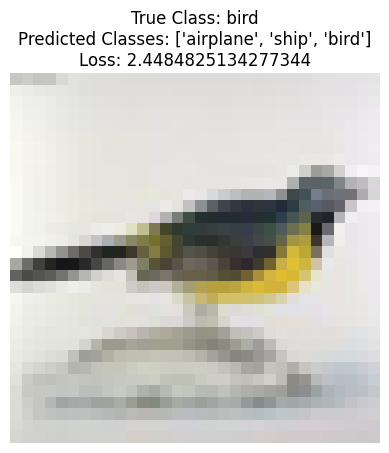

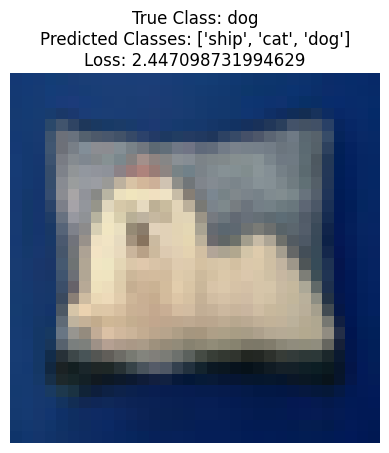

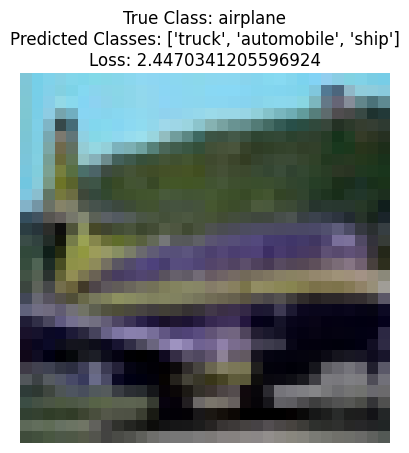

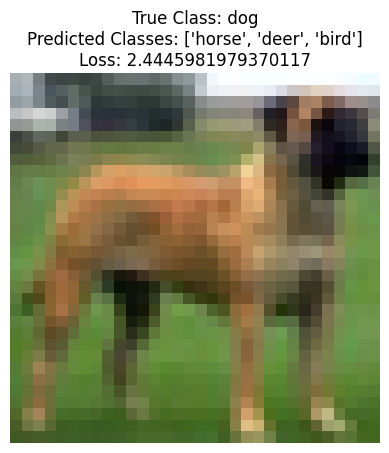

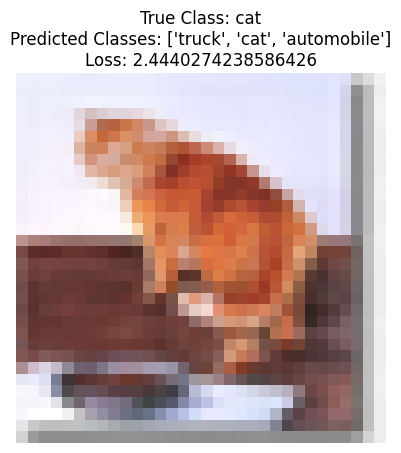

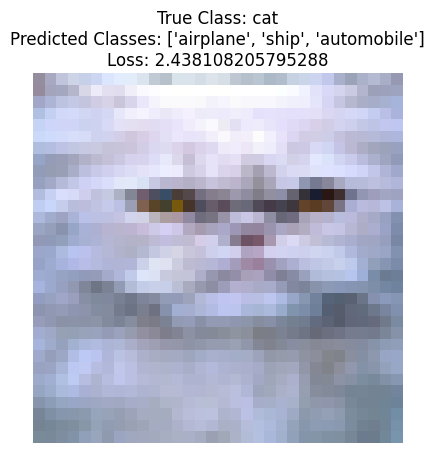

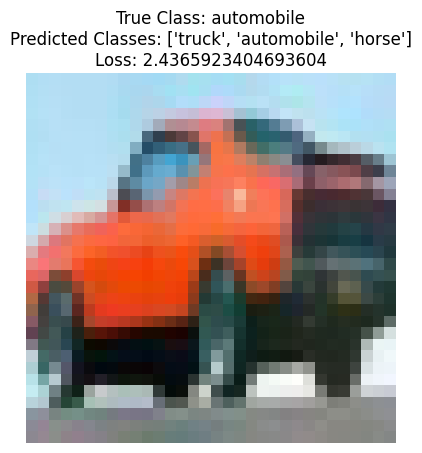

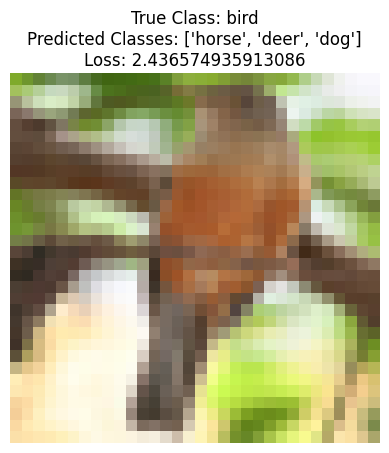

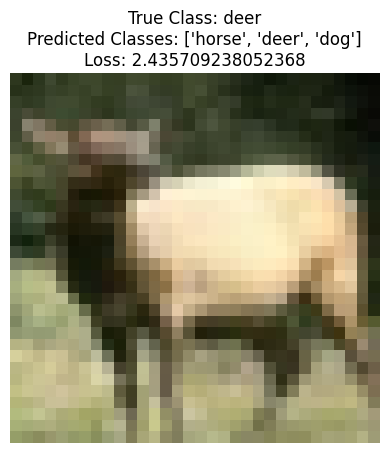

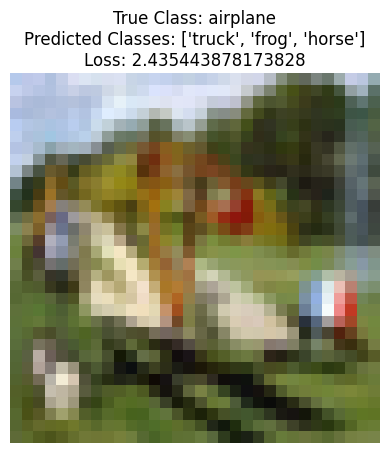

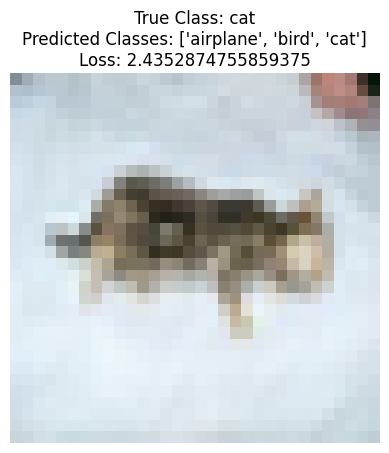

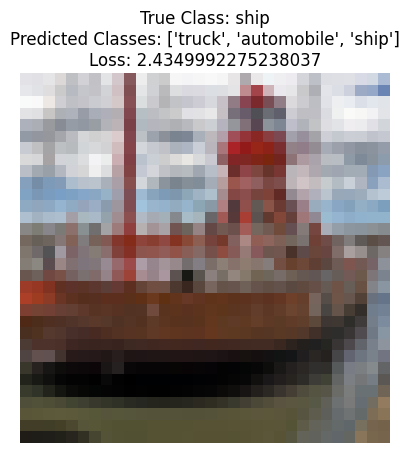

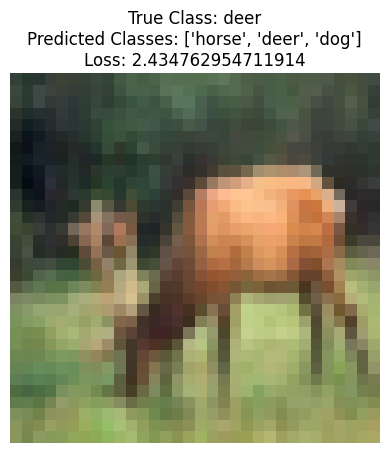

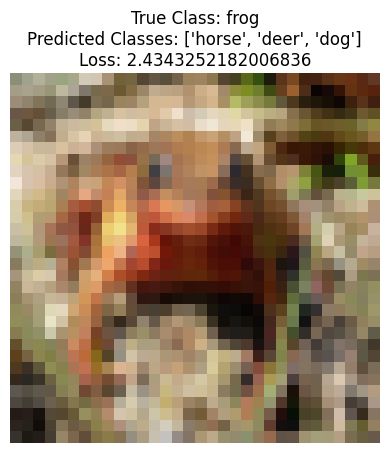

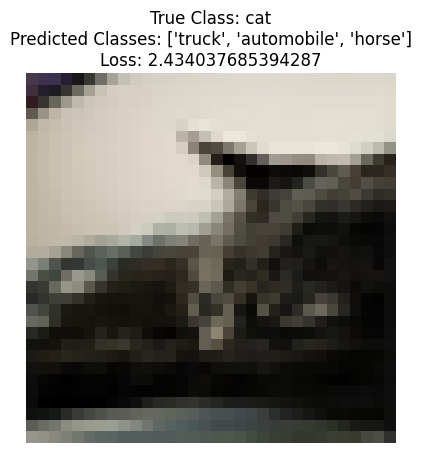

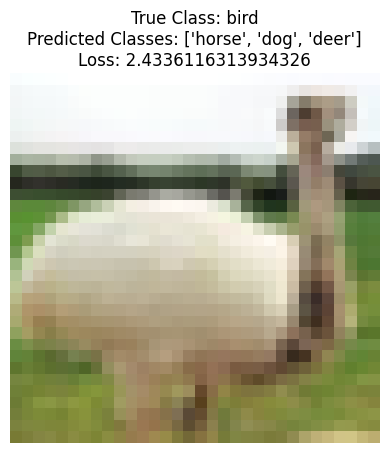

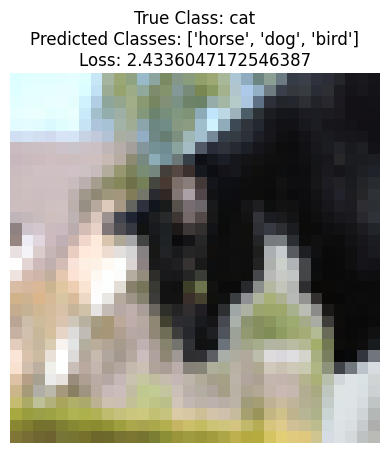

In [102]:
def show_image(image, title):
    plt.imshow(image.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

model = ConvNet(3, 10)
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'model_10epochs.pth')))
model.eval()

misclassified_images = []

for i, (image, label) in enumerate(test_data):
    image = image.view(-1, 3, 32, 32)
    label = label.reshape(1)
    output = model(image)
    loss = model.get_loss(output, label)

    _, predicted = torch.max(output, 1)
    if predicted != label:
        misclassified_images.append((image, label, predicted, loss.item(), output))

misclassified_images.sort(key=lambda x: x[3], reverse=True)

for i in range(20):
    image, true_label, predicted_label, loss, output = misclassified_images[i]
    true_class = ds_test.classes[true_label]
    predicted_classes = [ds_test.classes[predicted_label.item()] for predicted_label in torch.topk(output, 3).indices.squeeze()]

    show_image(image.cpu().squeeze(), f'True Class: {true_class}\nPredicted Classes: {predicted_classes}\nLoss: {loss}')


In [106]:
def multiclass_hinge_loss(logits: torch.Tensor, target: torch.Tensor, delta=1.):
    """
        Args:
            logits: torch.Tensor with shape (B, C), where B is batch size, and C is number of classes.
            target: torch.LongTensor with shape (B, ) representing ground truth labels.
            delta: Hyperparameter.
        Returns:
            Loss as scalar torch.Tensor.
    """
    B, C = logits.shape
    target = target.view(-1, 1)
    correct_logits = logits.gather(1, target)
    correct_logits = correct_logits.view(-1, 1)
    correct_logits = correct_logits.repeat(1, C)
    loss = torch.clamp(delta + logits - correct_logits, min=0)
    loss = loss.sum(dim=1)
    loss = loss.mean()
    return loss

Training (epoch=1/10): 100%|██████████| 1250/1250 [00:55<00:00, 22.42it/s, loss=4.49]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:622: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
Training (epoch=10/10): 100%|██████████| 1250/1250 [00:59<00:00, 21.02it/s, loss=2.76]


Plotting in:  ./out/convnet_training/training_plot.png


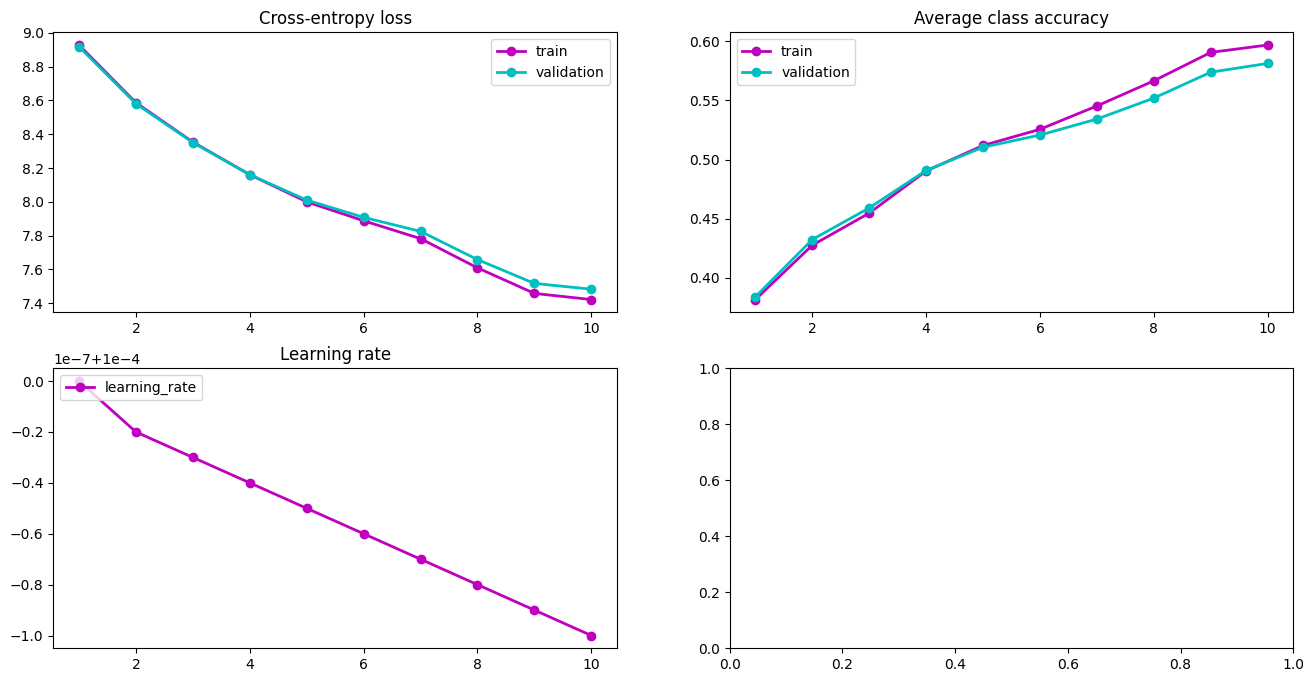

In [107]:
net = ConvNet(3, 10)

train(net, train_data, val_data, {'num_epochs':10, 'lr_decay':1-1e-4, 'lr':1e-4}, multiclass_hinge_loss)